#### Inicijalizacija

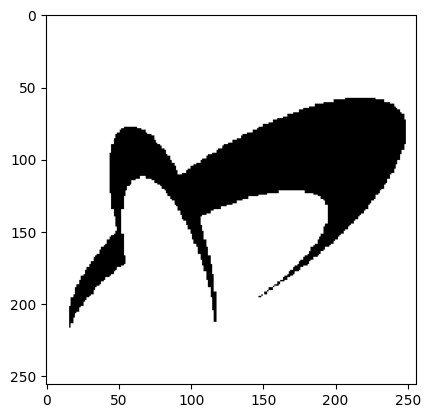

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
import transformations
import utils
%matplotlib inline

org_img = cv2.imread('../assets/imgs/Sunrise.png', 0)
gray_watermark_img = cv2.imread("../assets/imgs/raf_bw.png",cv2.IMREAD_GRAYSCALE)
_, watermark_bw = cv2.threshold(gray_watermark_img, 128, 255, cv2.THRESH_BINARY)
watermark_bw = watermark_bw//255


plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.imshow(watermark_bw, cmap='gray', vmin=0, vmax=1)


#### Kodiranje poruke u QR kod i embedovanje u neki sloj bitova

(2560, 2560)


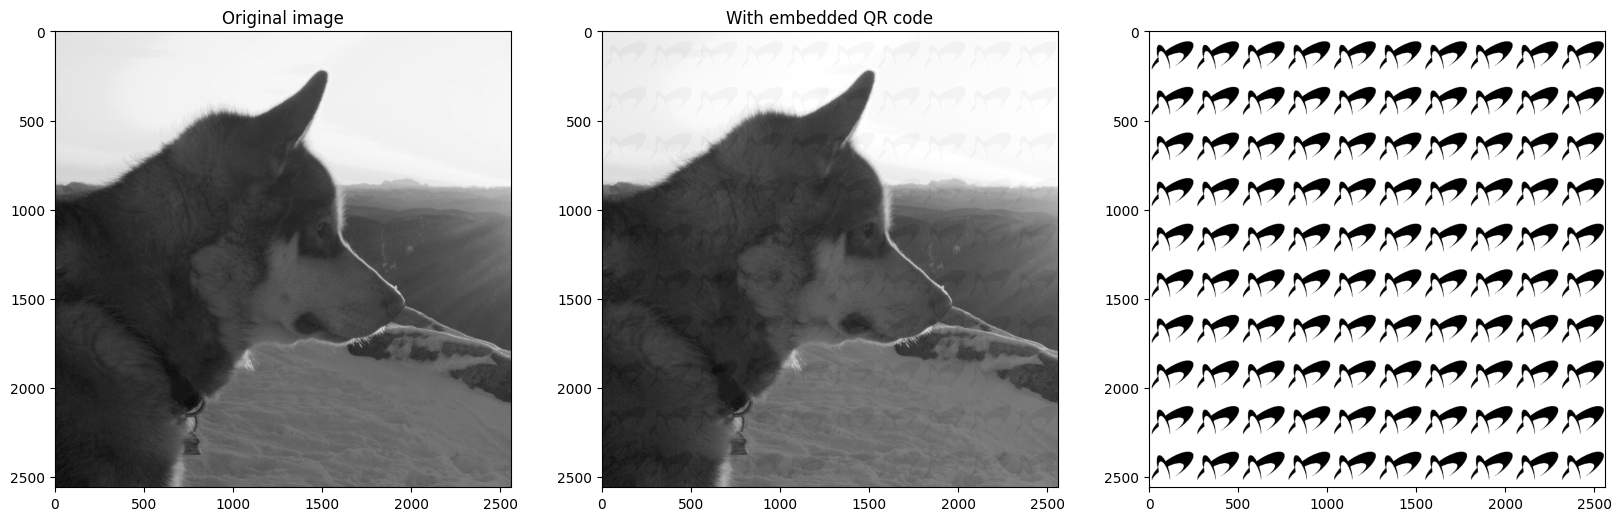

In [2]:
from qreader import QReader
from embeders.BitLayerEmbeder import BitLayerEmbeder

layer = 3

grid_watermark_bw = utils.generate_tiled_image(watermark_bw, org_img.shape)


embeder = BitLayerEmbeder()
embedded_img = embeder.encode(org_img, grid_watermark_bw, dict(layer=layer))

transformed_img = embedded_img
decoded_img = embeder.decode(transformed_img, layer)


dropped_img = transformations.drop_bit_layer(org_img, layer)

plt.figure(figsize=(20, 20))
plt.subplot(1, 3, 1)
#plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.imshow(dropped_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.subplot(1, 3, 2)
plt.imshow(transformed_img, cmap='gray', vmin=0, vmax=255)
plt.title('With embedded QR code')
plt.subplot(1, 3, 3)
plt.imshow(decoded_img, cmap='gray', vmin=0, vmax=1)



#### Kodiranjem q0 i q1 pseudo sume kako bismo kodirali 0 u 1 u slici

Text(0.5, 1.0, 'Decoded image')

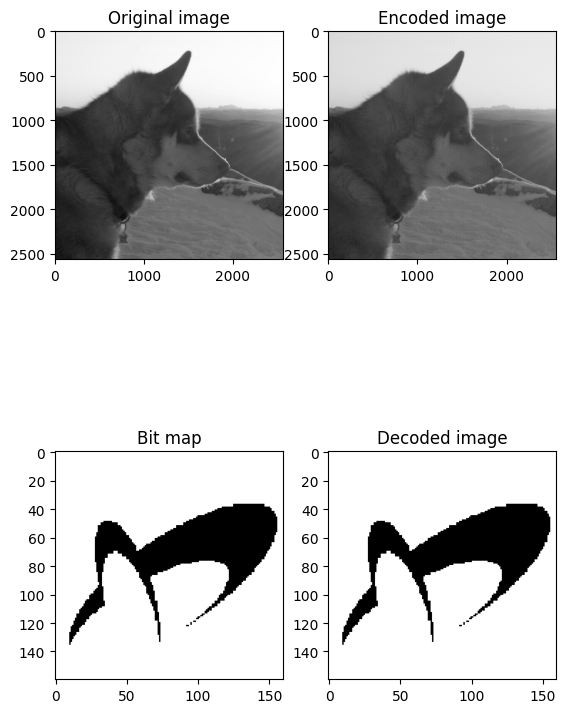

In [ ]:
from embeders.PatchworkEmbeder import PatchworkEmbeder

# size of square used to embed one bit
bit_square_size = 16
# noise type to be added to the image, can be 'gaussian' or 'salt_and_pepper'
noise_type = 'gaussian'
# noise level to be added to the image, can be a value between 0 and 1
noise_level = 0.15

embeder = PatchworkEmbeder(bit_square_size, noise_type)


vertical_size = org_img.shape[0]//bit_square_size
horizontal_size = org_img.shape[1]//bit_square_size

resized_watermark = cv2.resize(watermark_bw, (horizontal_size, vertical_size), interpolation=cv2.INTER_NEAREST)


encoded_img = embeder.encode(org_img,resized_watermark, noise_level)
decoded_img = embeder.decode(encoded_img)


plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.subplot(2, 3, 2)
plt.imshow(encoded_img, cmap='gray', vmin=0, vmax=255)
plt.title('Encoded image')
plt.subplot(2, 3, 4)
plt.imshow(resized_watermark, cmap='gray', vmin=0, vmax=1)
plt.title('Original watermark')
plt.subplot(2, 3, 5)
plt.imshow(decoded_img, cmap='gray', vmin=0, vmax=1)
plt.title('Decoded image')










#### SVD 

Text(0.5, 1.0, 'Extracted watermark')

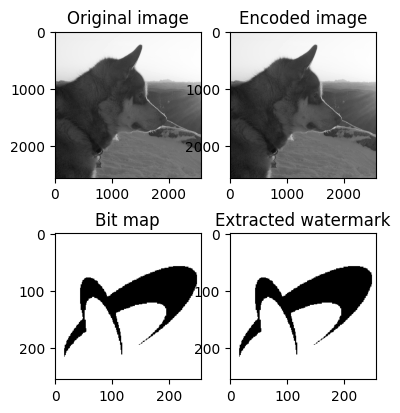

In [6]:
from transformers.SvdTransformator import SvdTransformator
from utils import fit_to_size


alpha = 0.1
transformator = SvdTransformator()
U, S, V = transformator.forwardTransform(org_img)
D = S + alpha * fit_to_size(watermark_bw, S.shape)

U1, S1, V1 = transformator.forwardTransform(D)
encoded_img = transformator.backwardTransform(U, S1, V)

Ur, Sr, Vr = transformator.forwardTransform(encoded_img)
Dr = transformator.backwardTransform(U1, Sr, V1)

extracted_watermark = (Dr - S) / alpha
extracted_watermark = fit_to_size(extracted_watermark, watermark_bw.shape, True)

plt.subplot(2, 3, 1)
plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.subplot(2, 3, 2)
plt.imshow(encoded_img, cmap='gray', vmin=0, vmax=255)
plt.title('Encoded image')
plt.subplot(2, 3, 4)
plt.imshow(watermark_bw, cmap='gray', vmin=0, vmax=1)
plt.title('Bit map')
plt.subplot(2, 3, 5)
plt.imshow(extracted_watermark, cmap='gray', vmin=0, vmax=1)
plt.title('Extracted watermark')


### Frequency-flipping

In [ ]:
from embeders.PixelFlipperEmbeder import PixelFlipperEmbeder
from transformers.DctTransformator import DctTransformator

c1=(3,0)
c2=(1,2)
bit_square_size = 16

embeder = PixelFlipperEmbeder({'coord1':c1,'coord2':c2, 'block_size':bit_square_size})
transformations = DctTransformator({'block_size':bit_square_size})

dct_result = transformations.forwardTransform(org_img)
dct_embedded = embeder.encode(dct_result, watermark_bw)
img_with_watermark = transformations.backwardTransform(dct_embedded)

dct_with_watermark = transformations.forwardTransform(img_with_watermark)
extracted_watermark = embeder.decode(dct_with_watermark)

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.subplot(2, 3, 2)
plt.imshow(img_with_watermark, cmap='gray', vmin=0, vmax=255)
plt.title('Image with watermark')
plt.subplot(2, 3, 4)
plt.imshow(watermark_bw, cmap='gray', vmin=0, vmax=1)
plt.title('Bit map')
plt.subplot(2, 3, 5)





ImportError: cannot import name 'Watermarker' from 'embeders.Embeder' (c:\Users\dvasiljevic\OneDrive - Microsoft\Diplomiski\src\embeders\Embeder.py)

available blocks: 92416
order start: [50256 87105 39569  2285 39038 51079 23841  8198 61445  3720]
31 31.4765625
57 57.09375
23 23.296875
123 123.46875
23 23.203125
19 19.4765625
29 29.125
125 125.015625
27 27.4921875
121 121.109375
25 25.3125
117 117.3203125
53 53.4921875
31 31.1484375
67 67.0390625
125 125.203125
25 25.46875
29 29.078125
67 67.2734375
117 117.359375
19 19.078125
39 39.0546875
27 27.4765625
31 31.2578125
125 125.5
31 31.0625
55 55.28125
117 117.0390625
31 31.09375
79 79.2734375
31 31.46875
19 19.0234375
59 59.0390625
35 35.4609375
35 35.3125
53 53.109375
37 37.390625
57 57.0234375
119 119.4765625
119 119.4765625
21 21.2890625
53 53.0390625
125 125.4765625
35 35.0859375
29 29.0390625
119 119.234375
25 25.21875
21 21.3671875
19 19.0703125
125 125.375
available blocks: 92416
order start: [50256 87105 39569  2285 39038 51079 23841  8198 61445  3720]
watermark shape: 25600
31 30.9765625
57 56.59375
23 22.796875
123 122.96875
23 22.703125
19 18.9765625
29 28.625
125 124.515

Text(0.5, 1.0, 'Decoded image')

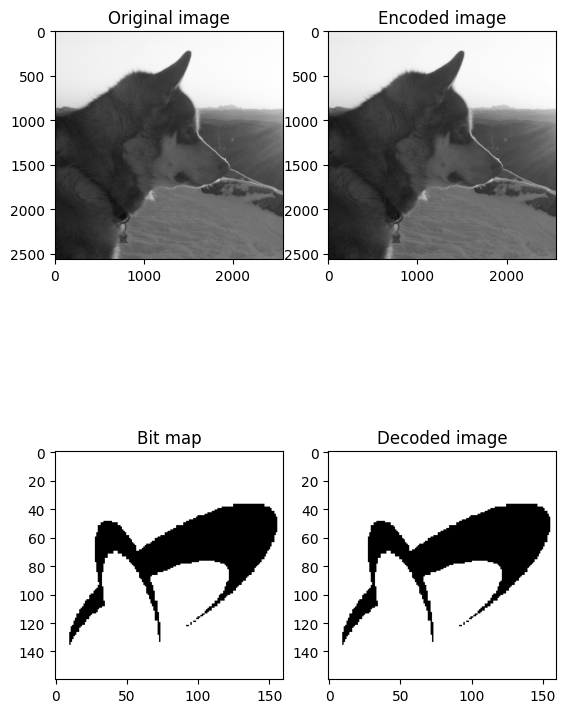

In [ ]:
from randomDCTWatermarker import RandomDCTWatermarker


watermarker = RandomDCTWatermarker(block_size=8, fact=16, permute=True)

encoded_img = watermarker.encode(org_img,resized_watermark)
decoded_img = watermarker.decode(encoded_img, resized_watermark.shape)




plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.subplot(2, 3, 2)
plt.imshow(encoded_img, cmap='gray', vmin=0, vmax=255)
plt.title('Encoded image')
plt.subplot(2, 3, 4)
plt.imshow(resized_watermark, cmap='gray', vmin=0, vmax=1)
plt.title('Bit map')
plt.subplot(2, 3, 5)
plt.imshow(decoded_img, cmap='gray', vmin=0, vmax=1)
plt.title('Decoded image')

-0.04278158481569761 255.01620317278193


Text(0.5, 1.0, 'Decoded image')

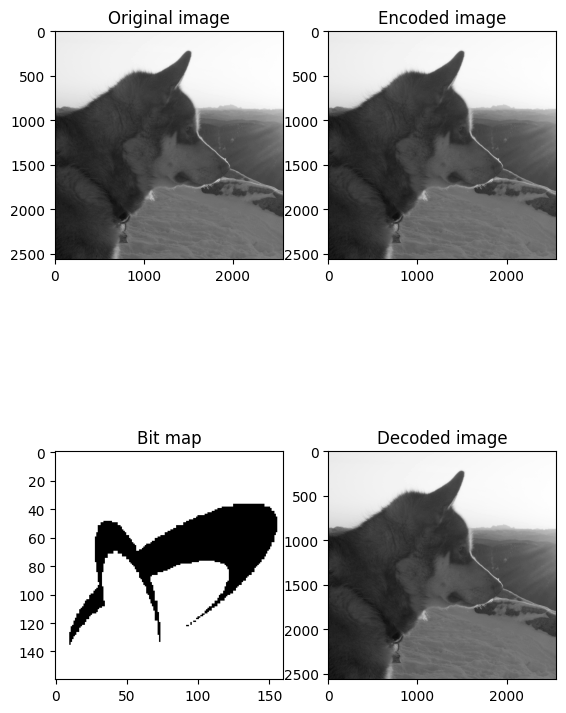

In [ ]:
from dctSvdWatermarker import DctSvdWatermarker


watermarker = DctSvdWatermarker()

encoded_img = watermarker.encode(org_img,resized_watermark)
decoded_img = watermarker.decode(encoded_img, org_img)

plt.figure(figsize=(10, 10))

plt.subplot(2, 3, 1)
plt.imshow(org_img, cmap='gray', vmin=0, vmax=255)
plt.title('Original image')
plt.subplot(2, 3, 2)
plt.imshow(encoded_img, cmap='gray', vmin=0, vmax=255)
plt.title('Encoded image')
plt.subplot(2, 3, 4)
plt.imshow(resized_watermark, cmap='gray', vmin=0, vmax=1)
plt.title('Bit map')
plt.subplot(2, 3, 5)
plt.imshow(decoded_img, cmap='gray', vmin=0, vmax=255)

print(min(decoded_img.flatten()), max(decoded_img.flatten()))
plt.title('Decoded image')